In [1]:
import numpy as np
import os
import cv2
import glob 

## 輸入待校正圖片

In [10]:
# 待校正之左右影像

# ==== 兼容 OpenCV 讀中文路徑圖片 ====
def imread_unicode(file_path):
    ''' 讀取包含中文路徑的圖片，回傳 BGR np.ndarray  '''
    # 用 numpy 讀二進位，再用 OpenCV 解碼
    img_array = np.fromfile(file_path, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img
# ===================================

# left_image_path = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\court\court_img_origin_L.jpg"
# right_image_path = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\court\court_img_origin_R.jpg"

left_image_path = r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_exp1_校正後圖片\court\origin_L.jpg"
right_image_path = r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_exp1_校正後圖片\court\origin_R.jpg"

# 使用支援中文路徑的函數讀取圖片
left_img = imread_unicode(left_image_path)
right_img = imread_unicode(right_image_path)

# 檢查圖片是否成功讀取
if left_img is None:
    raise FileNotFoundError(f"無法讀取左側圖片: {left_image_path}")
if right_img is None:
    raise FileNotFoundError(f"無法讀取右側圖片: {right_image_path}")

width = left_img.shape[1]
height = left_img.shape[0]
image_size = (width, height)

print("image_size (w,h):", image_size)

image_size (w,h): (1920, 1080)


## 單目標定

In [3]:
def _calibration_single_camera(
    image_folder, 
    chessboard_size=(9, 6), 
    square_size=0.1, 
    save_path='calibration_result.npz',
    batch_size=50, 
    show_corners=False):

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

    obj_points, img_points = [], []
    images = glob.glob(image_folder)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
        if ret:
            obj_points.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            img_points.append(corners2)
            if show_corners:
                cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
                cv2.imshow('Chessboard Corners', img)
                cv2.waitKey(100)
    if show_corners:
        cv2.destroyAllWindows()

    try:
        ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
            obj_points, img_points, gray.shape[::-1], None, None
        )
    except Exception:
        return None

    total_error = 0
    per_view_errors = []
    for i in range(len(obj_points)):
        projected_points, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
        projected_points = projected_points.reshape(-1, 2).astype(np.float32)
        img_pts = img_points[i].reshape(-1, 2).astype(np.float32)
        error = cv2.norm(img_pts, projected_points, cv2.NORM_L2) / len(projected_points)
        per_view_errors.append(error)
        total_error += error

    mean_reprojection_error = total_error / len(obj_points)
    fx, fy = camera_matrix[0, 0], camera_matrix[1, 1]
    cx, cy = camera_matrix[0, 2], camera_matrix[1, 2]
    focal_ratio = fx / fy
    k1, k2, p1, p2, k3 = dist_coeffs[0] if len(dist_coeffs[0]) >= 5 else (*dist_coeffs[0], 0)

    validation_results = {
        'mean_reprojection_error': mean_reprojection_error,
        'max_reprojection_error': max(per_view_errors),
        'min_reprojection_error': min(per_view_errors),
        'std_reprojection_error': np.std(per_view_errors),
        'per_view_errors': per_view_errors,
        'focal_lengths': (fx, fy),
        'principal_point': (cx, cy),
        'focal_ratio': focal_ratio,
        'distortion_coeffs': dist_coeffs[0].tolist()
    }

    np.savez(save_path, 
             camera_matrix=camera_matrix, 
             dist_coeffs=dist_coeffs, 
             rvecs=[],
             tvecs=[],
             validation_results=validation_results)

    return camera_matrix, dist_coeffs, [], [], validation_results

In [10]:
left_cam_with_validation = _calibration_single_camera(
    image_folder=r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\left\auto_pick_image\*.jpg",
    chessboard_size=(9, 6), 
    square_size=0.09, 
    save_path='./20260114_實驗/標定參數/20260114_left_single.npz',  
    show_corners=False)

right_cam_with_validation = _calibration_single_camera(
    image_folder=r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\right\auto_pick_image\*.jpg",
    chessboard_size=(9, 6), 
    square_size=0.09, 
    save_path='./20260114_實驗/標定參數/20260114_right_single.npz', 
    show_corners=False)

## 匯入單目校正參數

In [11]:
# 從保存的文件中讀取驗證結果
def load_validation_results(npz_path):
    """
    從保存的npz文件中讀取驗證結果
    """
    data = np.load(npz_path, allow_pickle=True)
    
    if 'validation_results' in data:
        validation_results = data['validation_results'].item() 
        print(f"從 {npz_path} 讀取驗證結果:")
        print(f"平均重投影誤差: {validation_results['mean_reprojection_error']:.4f} 像素")
        print(f"最大重投影誤差: {validation_results['max_reprojection_error']:.4f} 像素")
        print(f"最小重投影誤差: {validation_results['min_reprojection_error']:.4f} 像素")
        print(f"標準差: {validation_results['std_reprojection_error']:.4f} 像素")
        print(f"焦距: fx={validation_results['focal_lengths'][0]:.4f}, fy={validation_results['focal_lengths'][1]:.4f}")
        print(f"主點: cx={validation_results['principal_point'][0]:.4f}, cy={validation_results['principal_point'][1]:.4f}")
        print(f"焦距比: {validation_results['focal_ratio']:.4f}")
        print(f"畸變係數: {validation_results['distortion_coeffs']}")
        return validation_results
    else:
        print(f"文件 {npz_path} 中沒有驗證結果")
        return None

# 讀取並顯示驗證結果
print("=== 讀取左相機驗證結果 ===")
# left_validation = load_validation_results('./20260114_實驗/標定參數/20260114_left_single.npz')
left_validation = load_validation_results('./20251125_exp1_雙目參數檔/exp1/20251125_left_single_1_2.npz')

print("\n=== 讀取右相機驗證結果 ===")
# right_validation = load_validation_results('./20260114_實驗/標定參數/20260114_right_single.npz')
right_validation = load_validation_results('./20251125_exp1_雙目參數檔/exp1/20251125_right_single_1_2.npz')

=== 讀取左相機驗證結果 ===
從 ./20251125_exp1_雙目參數檔/exp1/20251125_left_single_1_2.npz 讀取驗證結果:
平均重投影誤差: 0.2034 像素
最大重投影誤差: 0.4863 像素
最小重投影誤差: 0.0995 像素
標準差: 0.1091 像素
焦距: fx=1375.8086, fy=1369.1617
主點: cx=920.6655, cy=576.4673
焦距比: 1.0049
畸變係數: [-0.44669934729018285, 0.28868046340036174, -0.0024543102132901684, 0.0017159365640038655, -0.107184265299273]

=== 讀取右相機驗證結果 ===
從 ./20251125_exp1_雙目參數檔/exp1/20251125_right_single_1_2.npz 讀取驗證結果:
平均重投影誤差: 0.1448 像素
最大重投影誤差: 0.2617 像素
最小重投影誤差: 0.0693 像素
標準差: 0.0551 像素
焦距: fx=1312.8524, fy=1302.9435
主點: cx=934.0810, cy=546.5923
焦距比: 1.0076
畸變係數: [-0.42970014097544607, 0.25357978693580885, -0.00022940617180953774, 0.001929724916157878, -0.0871064794728012]


In [14]:
# left_data = np.load('./20260114_實驗/標定參數/20260114_left_single.npz')
# right_data = np.load('./20260114_實驗/標定參數/20260114_right_single.npz')

left_data = np.load('./20251125_exp1_雙目參數檔/exp1/20251125_left_single_1_2.npz')
right_data = np.load('./20251125_exp1_雙目參數檔/exp1/20251125_right_single_1_2.npz')

mtxL = left_data['camera_matrix']
distL = left_data['dist_coeffs']

mtxR = right_data['camera_matrix']
distR = right_data['dist_coeffs']

print(f"mtxL: \n{mtxL}")
print(f"distL: \n{distL}")
print(f"mtxR: \n{mtxR}")
print(f"distR: \n{distR}")

mtxL: 
[[1.37580860e+03 0.00000000e+00 9.20665482e+02]
 [0.00000000e+00 1.36916168e+03 5.76467288e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distL: 
[[-0.44669935  0.28868046 -0.00245431  0.00171594 -0.10718427]]
mtxR: 
[[1.31285239e+03 0.00000000e+00 9.34081049e+02]
 [0.00000000e+00 1.30294346e+03 5.46592299e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distR: 
[[-4.29700141e-01  2.53579787e-01 -2.29406172e-04  1.92972492e-03
  -8.71064795e-02]]


## 畸變校正

In [15]:
import numpy as np
import cv2
# -------------------------- 畸變校正 ---------------------------------
def calibration(camera_matrix, dist_coeffs, un_cal_frame, w, h):
    # 計算新的相機矩陣
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 0, (w, h)) 

    # 矯正畸變
    dst = cv2.undistort(un_cal_frame, camera_matrix, dist_coeffs, None, new_camera_matrix)
    
    # 檢查 ROI 並裁剪圖像
    if roi is not None and all(roi):
        x, y, w, h = roi
        frame = dst[y:y+h, x:x+w]
        print(frame.shape)
    else:
        frame = dst  # 如果沒有有效 ROI，就用整張圖
    return frame

In [34]:
cam_param_L = np.load(r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20260114_實驗\標定參數\20260114_left_single.npz", allow_pickle=True)
mtxL = cam_param_L['camera_matrix']
distL = cam_param_L['dist_coeffs']
img_L = calibration(mtxL, distL, left_img, width, height)
cv2.imwrite('undistorted_img_L.jpg', img_L)

cam_param_R = np.load(r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20260114_實驗\標定參數\20260114_right_single.npz", allow_pickle=True)
mtxR = cam_param_R['camera_matrix']
distR = cam_param_R['dist_coeffs']
img_R = calibration(mtxR, distR, right_img, width, height)
cv2.imwrite('undistorted_img_R.jpg', img_R)

True

## 雙目標定

In [16]:
def _stereo_calibration(mtxL, mtxR, distL, distR, left_dir, right_dir):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5) 
    chessboard_size = (9, 6)
    square_size = 0.09

    # 建立棋盤格世界座標點（ Z=0 ）
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    objp *= square_size

    # 讀取左右相機同一幀下的棋盤格圖片
    left_images = sorted(glob.glob(os.path.join(left_dir, '*.jpg')))
    right_images = sorted(glob.glob(os.path.join(right_dir, '*.jpg')))

    imgpoints_left = []  # 左相機圖片2D點
    imgpoints_right = [] # 右相機圖片2D點
    objpoints = []       # 棋盤格世界座標點

    # 初始化影像尺寸變數
    image_size = None

    for frameL, frameR in zip(left_images, right_images):
        img_left = cv2.imread(frameL)
        img_right = cv2.imread(frameR)

        grayL = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        grayR = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

        if image_size is None:
            image_size = grayL.shape[::-1] if grayL.shape[::-1] == grayR.shape[::-1] else None

        retL, cornersL = cv2.findChessboardCorners(grayL, chessboard_size, None)
        retR, cornersR = cv2.findChessboardCorners(grayR, chessboard_size, None)

        if retL and retR:
            cornersL = cv2.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1), criteria)  # (11, 11) 是子像素搜索窗口大小，(-1, -1) 是停止迭代門檻值
            cornersR = cv2.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1), criteria)

            cv2.drawChessboardCorners(img_left, chessboard_size, cornersL, retL)
            cv2.imshow('img_left', img_left)
            cv2.drawChessboardCorners(img_right, chessboard_size, cornersR, retR)
            cv2.imshow('img_right', img_right)
            cv2.waitKey(500)

            objpoints.append(objp)
            imgpoints_left.append(cornersL)
            imgpoints_right.append(cornersR)

    # 顯示結束後關閉視窗
    cv2.waitKey(1)
    cv2.destroyAllWindows()

    # 固定內參，僅估計 R, T 外參
    # flags = cv2.CALIB_FIX_INTRINSIC
    flags = cv2.CALIB_USE_INTRINSIC_GUESS # 初始化最佳相機內參
    
    ret, mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_left, imgpoints_right,
        mtxL, distL, mtxR, distR,
        image_size, criteria=criteria, flags=flags)
    
    print(f"image_size: {image_size}")
    print(ret)  # ret 平均重投影誤差
    return mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, ret

In [17]:
# left_dir = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\stereo\left\auto_pick_stereo_image_L"
# right_dir = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\stereo\right\auto_pick_stereo_image_R"
left_dir = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20251125_chessboard_img\exp_1\dual\left\stereo_selected_final"
right_dir = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20251125_chessboard_img\exp_1\dual\right\stereo_selected_final"
mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, ret = _stereo_calibration(mtxL, mtxR, distL, distR, left_dir, right_dir)

# 將 R, T 存成 npz檔
np.savez('stereo_rt.npz', mtxL_opt=mtxL_opt, distL_opt=distL_opt, mtxR_opt=mtxR_opt, distR_opt=distR_opt, R=R, T=T, ret=ret)

image_size: (1920, 1080)
2.405795565017642


## 匯入雙目校正參數

In [8]:
# 從 npz 檔案匯入 R, T
data = np.load('./20260114_實驗/標定參數/stereo_rt.npz')
R = data['R']
T = data['T']

baseline = np.sqrt(T[0]**2 + T[1]**2 + T[2]**2)

from scipy.spatial.transform import Rotation as Rscipy

# 由R矩陣計算出沿X, Y, Z軸的旋轉角度（單位：度）
rot = Rscipy.from_matrix(R)
angles = rot.as_euler('xyz', degrees=True) 

print(f"R matrix:\n{R}\n")
print(f"T vector:\n{T}\n")
print(f"baseline: {baseline} m\n")

R matrix:
[[ 0.40943929 -0.21167475  0.88744198]
 [ 0.23351226  0.96462568  0.12234919]
 [-0.88194756  0.15713402  0.4443843 ]]

T vector:
[[-5.23471105]
 [-0.6354926 ]
 [ 2.85377202]]

baseline: [5.99583733] m



## 建構P1、P2矩陣

In [4]:
import numpy as np
import cv2

# ================= 1. 讀取參數 =================
try:
    # 載入左相機內參
    left_data = np.load('./20260114_實驗/標定參數/20260114_left_single.npz')
    mtxL = left_data['camera_matrix']
    distL = left_data['dist_coeffs']

    # 載入右相機內參
    right_data = np.load('./20260114_實驗/標定參數/20260114_right_single.npz')
    mtxR = right_data['camera_matrix']
    distR = right_data['dist_coeffs']

    # 載入雙目外參 (R, T)
    stereo_data = np.load('./20260114_實驗/標定參數/stereo_rt.npz')
    R = stereo_data['R']
    T = stereo_data['T']

except FileNotFoundError as e:
    print(f"錯誤：找不到檔案，請檢查路徑。\n{e}")

# ================= 2. 建構投影矩陣 P (3x4) =================
# 左相機投影矩陣 (世界座標系原點設在左相機光心)
RT_L = np.hstack((np.eye(3), np.zeros((3,1)))) # [I | 0]
P_L_original = mtxL @ RT_L

# 右相機投影矩陣 (相對於左相機的旋轉與平移)
RT_R = np.hstack((R, T)) # [R | T]
P_R_original = mtxR @ RT_R

print("--- Projection Matrices Constructed ---")
print(f"mtxL : \n{mtxL}")
# print(f"distL : {distL}")
print(f"mtxR : \n{mtxR}")
# print(f"distR : {distR}")
# print(f"P_Left shape: {P_L_original.shape}")
print(f"P_left : \n{P_L_original}")
# print(f"P_Right shape: {P_R_original.shape}")
print(f"P_Right : \n{P_R_original}")

--- Projection Matrices Constructed ---
mtxL : 
[[1.23889562e+03 0.00000000e+00 9.70436525e+02]
 [0.00000000e+00 1.23787685e+03 5.45968096e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
mtxR : 
[[1.30422463e+03 0.00000000e+00 9.98074084e+02]
 [0.00000000e+00 1.29638918e+03 5.15310566e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
P_left : 
[[1.23889562e+03 0.00000000e+00 9.70436525e+02 0.00000000e+00]
 [0.00000000e+00 1.23787685e+03 5.45968096e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
P_Right : 
[[-3.46248201e+02 -1.19240029e+02  1.60095214e+03 -3.97896316e+03]
 [-1.51754127e+02  1.33150311e+03  3.87608087e+02  6.46733152e+02]
 [-8.81947558e-01  1.57134019e-01  4.44384299e-01  2.85377202e+00]]


## 選取座標點

In [41]:
import cv2
import json
import numpy as np

# === 配置區 ===
LEFT_IMG_PATH = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\court\court_img_origin_L.jpg"
RIGHT_IMG_PATH = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20260114_chessboard_img\court\court_img_origin_R.jpg"
SAVE_JSON_PATH = "./20260114_實驗/左右對應座標/court_point.json"
NUM_POINTS = 15

def imread_unicode(path):
    """支援中文路徑的影像讀取"""
    return cv2.imdecode(np.fromfile(path, np.uint8), cv2.IMREAD_COLOR)

def interactive_point_select(img, win_name, num_points=15, zoom_size=60, zoom_ratio=4, show_zoom=True):
    """互動選點，支援滑鼠放大鏡檢視與即時可視化。"""
    points = []
    img_disp = img.copy()
    zoom_win = f"{win_name}_zoom"

    def show_zoom(x, y):
        if not show_zoom:
            return
        h, w = img.shape[:2]
        left, right = max(x - zoom_size//2, 0), min(x + zoom_size//2, w)
        top, bottom = max(y - zoom_size//2, 0), min(y + zoom_size//2, h)
        roi = img[top:bottom, left:right]
        # 邊緣補白
        pad = np.zeros((zoom_size, zoom_size, 3), dtype=np.uint8)
        y0, x0 = max(0, -(y - zoom_size//2)), max(0, -(x - zoom_size//2))
        ph, pw = roi.shape[:2]
        pad[y0:y0+ph, x0:x0+pw] = roi
        zoom = cv2.resize(pad, (zoom_size*zoom_ratio, zoom_size*zoom_ratio), interpolation=cv2.INTER_NEAREST)
        center = zoom_size * zoom_ratio // 2
        cv2.drawMarker(zoom, (center, center), (0,255,0), markerType=cv2.MARKER_CROSS, markerSize=28, thickness=2)
        cv2.imshow(zoom_win, zoom)

    def mouse_cb(event, x, y, flags, param):
        show_zoom(x, y)
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < num_points:
            print(f"{win_name} 點選座標: ({x}, {y})")
            points.append((int(x), int(y)))
            cv2.circle(img_disp, (x, y), 5, (0,0,255), -1)
            cv2.imshow(win_name, img_disp)

    print(f"請於『{win_name}』依序點選 {num_points} 個點")
    cv2.namedWindow(win_name)
    if show_zoom:
        cv2.namedWindow(zoom_win)
    cv2.setMouseCallback(win_name, mouse_cb)
    cv2.imshow(win_name, img_disp)
    while len(points) < num_points:
        if cv2.waitKey(1) & 0xFF == 27:  # ESC
            break
    cv2.destroyWindow(win_name)
    if show_zoom:
        cv2.destroyWindow(zoom_win)
    print(f"{win_name} 已選取 {len(points)} 個點\n")
    return points

def save_point_pairs(left_pts, right_pts, save_path, num_points):
    """將左右相對點配對並存成 JSON，並於終端顯示。"""
    if len(left_pts) != num_points or len(right_pts) != num_points:
        print(f"警告：兩邊點數未滿 {num_points}，請重新操作。")
        return
    pairs = {
        f"point{i+1}": {"left": list(l), "right": list(r)}
        for i, (l, r) in enumerate(zip(left_pts, right_pts))
    }
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(pairs, f, ensure_ascii=False, indent=4)
    print(f"\n已儲存 {num_points} 對點於 {save_path}\n")
    print("====== 點選結果 ======")
    for i in range(num_points):
        p = pairs[f"point{i+1}"]
        print(f"point{i+1}:")
        print(f"    left : {tuple(p['left'])}")
        print(f"    right: {tuple(p['right'])}")

# 執行主程式
if __name__ == "__main__" or True:
    left_img = imread_unicode(LEFT_IMG_PATH)
    right_img = imread_unicode(RIGHT_IMG_PATH)
    left_points = interactive_point_select(left_img, "left_img", NUM_POINTS)
    right_points = interactive_point_select(right_img, "right_img", NUM_POINTS)
    save_point_pairs(left_points, right_points, SAVE_JSON_PATH, NUM_POINTS)


請於『left_img』依序點選 15 個點
left_img 點選座標: (1696, 548)
left_img 點選座標: (1179, 368)
left_img 點選座標: (1107, 346)
left_img 點選座標: (1665, 562)
left_img 點選座標: (1130, 372)
left_img 點選座標: (1056, 349)
left_img 點選座標: (1368, 688)
left_img 點選座標: (777, 406)
left_img 點選座標: (721, 379)
left_img 點選座標: (548, 962)
left_img 點選座標: (315, 469)
left_img 點選座標: (302, 432)
left_img 點選座標: (345, 1011)
left_img 點選座標: (230, 482)
left_img 點選座標: (226, 445)
left_img 已選取 15 個點

請於『right_img』依序點選 15 個點
right_img 點選座標: (1557, 994)
right_img 點選座標: (1656, 418)
right_img 點選座標: (1659, 378)
right_img 點選座標: (1333, 947)
right_img 點選座標: (1562, 407)
right_img 點選座標: (1576, 369)
right_img 點選座標: (458, 695)
right_img 點選座標: (1065, 360)
right_img 點選座標: (1124, 330)
right_img 點選座標: (148, 573)
right_img 點選座標: (695, 343)
right_img 點選座標: (771, 315)
right_img 點選座標: (116, 560)
right_img 點選座標: (645, 341)
right_img 點選座標: (720, 314)
right_img 已選取 15 個點


已儲存 15 對點於 ./20260114_實驗/左右對應座標/court_point.json

====== 點選結果 ======
point1:
    left : (1696, 548)


## 三角測量函數 (含畸變校正)

In [42]:
def calculate_3d_linear(u_L, v_L, u_R, v_R):
    """
    輸入左右相機的像素座標 (Pixel Coordinates)，
    輸出相對於左相機的 3D 座標 (X, Y, Z)。
    """

    # 1. 格式轉換：轉為 float32 的 numpy array，形狀必須是 (N, 1, 2)
    pt_L = np.array([[[u_L, v_L]]], dtype=np.float32)
    pt_R = np.array([[[u_R, v_R]]], dtype=np.float32)

    # 2. 畸變校正 (Undistort Points)
    # 關鍵：這裡我們傳入 P=mtxL、mtxR，是為了讓輸出保持在「像素座標系」。
    # 如果不傳 P，預設會輸出歸一化平面座標 (Normalized coords)，那樣後面的 P 矩陣就不能包含 K。
    undist_pts_L = cv2.undistortPoints(pt_L, mtxL, distL, P=mtxL)
    undist_pts_R = cv2.undistortPoints(pt_R, mtxR, distR, P=mtxR)

    # 3. 線性三角測量 (Linear Triangulation)
    # 輸出為 4D 齊次座標 (Homogeneous Coordinates) [X, Y, Z, W]
    points_4d = cv2.triangulatePoints(P_L_original, P_R_original, undist_pts_L, undist_pts_R)

    # 4. 歸一化：將齊次座標轉為歐氏座標
    X = points_4d[0] / points_4d[3]
    Y = points_4d[1] / points_4d[3]
    Z = points_4d[2] / points_4d[3]

    return np.array([X[0], Y[0], Z[0]])
    

In [43]:
import json

def load_correspondence_points(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def compute_and_save_3d_points(corr_points, output_path):
    coords_3d_dict = {}
    for i in range(1, 16):
        pt = corr_points[f'point{i}']
        u_L, v_L = pt['left']
        u_R, v_R = pt['right']
        coord_3d = calculate_3d_linear(u_L, v_L, u_R, v_R)
        coords_3d_dict[f"point{i}"] = list(map(float, coord_3d))
        print(f"point{i}: 3D座標 (X, Y, Z) = {coord_3d}")

    with open(output_path, 'w', encoding='utf-8') as f3d:
        json.dump(coords_3d_dict, f3d, ensure_ascii=False, indent=4)
    print(f"\n已將15組3D對應點儲存於 {output_path}")

if __name__ == '__main__' or True:
    json_path = './20260114_實驗/左右對應座標/court_point.json'
    output_path = './20260114_實驗/左右對應座標/court_3dpoints.json'
    corr_points = load_correspondence_points(json_path)
    compute_and_save_3d_points(corr_points, output_path)

point1: 3D座標 (X, Y, Z) = [ 3.6729383  -0.00918837  5.3083935 ]
point2: 3D座標 (X, Y, Z) = [ 1.4169018 -1.1936928  8.231784 ]
point3: 3D座標 (X, Y, Z) = [ 0.98654443 -1.4246831   8.789149  ]
point4: 3D座標 (X, Y, Z) = [3.3044717  0.05537237 5.0717797 ]
point5: 3D座標 (X, Y, Z) = [ 1.045109  -1.1245707  7.9774494]
point6: 3D座標 (X, Y, Z) = [ 0.600639  -1.3584262  8.558148 ]
point7: 3D座標 (X, Y, Z) = [1.2388606 0.4373598 3.6759033]
point8: 3D座標 (X, Y, Z) = [-1.0437922 -0.7519854  6.584868 ]
point9: 3D座標 (X, Y, Z) = [-1.4720309  -0.97684103  7.1361303 ]
point10: 3D座標 (X, Y, Z) = [-0.84344214  0.83652234  2.2317803 ]
point11: 3D座標 (X, Y, Z) = [-3.1077354  -0.35942435  5.1379128 ]
point12: 3D座標 (X, Y, Z) = [-3.5492456 -0.5971179  5.7041993]
point13: 3D座標 (X, Y, Z) = [-1.207268    0.90659183  1.9708549 ]
point14: 3D座標 (X, Y, Z) = [-3.481152  -0.2942258  4.884924 ]
point15: 3D座標 (X, Y, Z) = [-3.9184666 -0.5258307  5.4437633]

已將15組3D對應點儲存於 ./20260114_實驗/左右對應座標/court_3dpoints.json


## 讀取 vicon 資料

In [44]:
import pandas as pd

vicon_csv_path = r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20260114_實驗\Vicon_court\court_15points.csv"
vicon_df = pd.read_csv(vicon_csv_path)

points_info = [
    {"name": "point1", "cols": (2, 5)},
    {"name": "point2", "cols": (5, 8)},
    {"name": "point3", "cols": (8, 11)},
    {"name": "point4", "cols": (11, 14)},
    {"name": "point5", "cols": (14, 17)},
    {"name": "point6", "cols": (17, 20)},
    {"name": "point7", "cols": (20, 23)},
    {"name": "point8", "cols": (23, 26)},
    {"name": "point9", "cols": (26, 29)},
    {"name": "point10", "cols": (29, 32)},
    {"name": "point11", "cols": (32, 35)},
    {"name": "point12", "cols": (35, 38)},
    {"name": "point13", "cols": (38, 41)},
    {"name": "point14", "cols": (41, 44)},
    {"name": "point15", "cols": (44, 47)},
]

vicon_3d_points = {}
for point in points_info:
    # 取得第1橫列對應座標的值，轉為 float 並由 mm 轉至 m
    values_mm = vicon_df.iloc[1, point["cols"][0]:point["cols"][1]].values.astype(float)
    values_m = (values_mm / 1000).tolist()
    vicon_3d_points[point["name"]] = values_m
    print(f"{point['name']} values ({point['cols'][0]+1}~{point['cols'][1]}行) :", values_m)
    

point1 values (3~5行) : [-3.030553847, 3.937829452, 0.0316386034]
point2 values (6~8行) : [-3.030553847, 0.006983708512, 0.0316386034]
point3 values (9~11行) : [-3.028160263, -0.7523580147, 0.0310214564]
point4 values (12~14行) : [-2.564469439, 3.937829452, 0.037573348709999996]
point5 values (15~17行) : [-2.563660186, 0.008913318842000001, 0.02905614376]
point6 values (18~20行) : [-2.563737479, -0.7538496606999999, 0.02817077082]
point7 values (21~23行) : [0.007011309558, 3.939526979, 0.029636788419999997]
point8 values (24~26行) : [0.0112369723, 0.0064935022050000004, 0.0075195302880000005]
point9 values (27~29行) : [0.007989137549, -0.7558055579, 0.005032235479]
point10 values (30~32行) : [2.585252036, 3.933033301, 0.0131095992]
point11 values (33~35行) : [2.583171116, 0.008999713219, -0.002060065042]
point12 values (36~38行) : [2.5834705990000004, -0.7566220689, -0.001080695512]
point13 values (39~41行) : [3.045871071, 3.933937273, 0.01170064355]
point14 values (42~44行) : [3.042278166, 0.011370

In [45]:
import json

# 將 vicon_3d_points 依據順序存成 JSON 檔，與 correspond_points_3d_originimg_newbasis.json 格式一樣
# 排序 by point1~point15
sorted_vicon_3d_points = {}
for i in range(1, 16):
    key = f"point{i}"
    if key in vicon_3d_points:
        sorted_vicon_3d_points[key] = vicon_3d_points[key]

vicon_json_save_path = "vicon_3Dpoints.json"
with open(vicon_json_save_path, "w", encoding="utf-8") as f:
    json.dump(sorted_vicon_3d_points, f, ensure_ascii=False, indent=4)

print(f"已將 vicon_3d_points 存成 {vicon_json_save_path}")


已將 vicon_3d_points 存成 vicon_3Dpoints.json


In [47]:
import json

# 讀取 vicon_3d_points.json 檔案並存成 vicon_3d_points
with open("./20260114_實驗/Vicon_court/vicon_3Dpoints.json", "r", encoding="utf-8") as f:
    vicon_3d_points = json.load(f)

## 計算誤差

In [49]:
# 3D 誤差
import numpy as np
import json

# 從 JSON 檔案匯入 points_new_basis 的資料
with open("./20260114_實驗/左右對應座標/court_3Dpoints_svd.json", "r", encoding="utf-8") as fin:
    points_new_basis = json.load(fin)

errors = {}
# 取兩者都有的點，並排序（確保是 point1, point2, ... 的順序）
sorted_point_names = sorted(
    set(points_new_basis.keys()) & set(vicon_3d_points.keys()),
    key=lambda x: int(x.replace("point", ""))  # 依名稱排序
)

for key in sorted_point_names:
    point_new_basis = np.array(points_new_basis[key])
    point_vicon = np.array(vicon_3d_points[key])
    # 計算歐氏距離
    error = np.linalg.norm(point_new_basis - point_vicon)
    errors[key] = error
    print(f"{key} 的誤差: {error:.4f} m")

# 計算平均誤差
if errors:
    mean_error = np.mean(list(errors.values()))
    std_error = np.std(list(errors.values()))
    print(f"\n平均誤差: {mean_error:.4f} m, 標準差: {std_error} m")
else:
    print("無法找到共同點進行比較。")


point1 的誤差: 0.0431 m
point2 的誤差: 0.0602 m
point3 的誤差: 0.0719 m
point4 的誤差: 0.0351 m
point5 的誤差: 0.0491 m
point6 的誤差: 0.0465 m
point7 的誤差: 0.0696 m
point8 的誤差: 0.0106 m
point9 的誤差: 0.0210 m
point10 的誤差: 0.0677 m
point11 的誤差: 0.0220 m
point12 的誤差: 0.0230 m
point13 的誤差: 0.0693 m
point14 的誤差: 0.0248 m
point15 的誤差: 0.0263 m

平均誤差: 0.0427 m, 標準差: 0.02040795299660735 m


In [50]:
# 2D (x, y) 誤差計算
import numpy as np
import json

# 從 JSON 檔案匯入 points_new_basis 的資料
with open("./20260114_實驗/左右對應座標/court_3Dpoints_svd.json", "r", encoding="utf-8") as fin:
    points_new_basis = json.load(fin)

errors = {}

# 保證 points 依 point1, point2, ..., point15 (1~15) 排序
sorted_point_names = [
    f"point{i}" for i in range(1, 16)
    if f"point{i}" in points_new_basis and f"point{i}" in vicon_3d_points
]

for key in sorted_point_names:
    point_new_basis_xy = np.array(points_new_basis[key][:2])  # 取 x, y
    point_vicon_xy = np.array(vicon_3d_points[key][:2])       # 取 x, y
    # 計算只有 x, y 的歐氏距離
    error = np.linalg.norm(point_new_basis_xy - point_vicon_xy)
    errors[key] = error
    print(f"{key} 的(x, y)誤差: {error:.4f} m")

# 計算平均誤差、標準差
if errors:
    mean_error = np.mean(list(errors.values()))
    std_error = np.std(list(errors.values()))
    print(f"\n2D (x, y)平均誤差: {mean_error:.4f} m, 標準差: {std_error:.4f} m")
else:
    print("無法找到共同點進行比較。")

point1 的(x, y)誤差: 0.0403 m
point2 的(x, y)誤差: 0.0600 m
point3 的(x, y)誤差: 0.0719 m
point4 的(x, y)誤差: 0.0347 m
point5 的(x, y)誤差: 0.0488 m
point6 的(x, y)誤差: 0.0455 m
point7 的(x, y)誤差: 0.0694 m
point8 的(x, y)誤差: 0.0097 m
point9 的(x, y)誤差: 0.0207 m
point10 的(x, y)誤差: 0.0672 m
point11 的(x, y)誤差: 0.0218 m
point12 的(x, y)誤差: 0.0224 m
point13 的(x, y)誤差: 0.0689 m
point14 的(x, y)誤差: 0.0245 m
point15 的(x, y)誤差: 0.0260 m

2D (x, y)平均誤差: 0.0421 m, 標準差: 0.0205 m


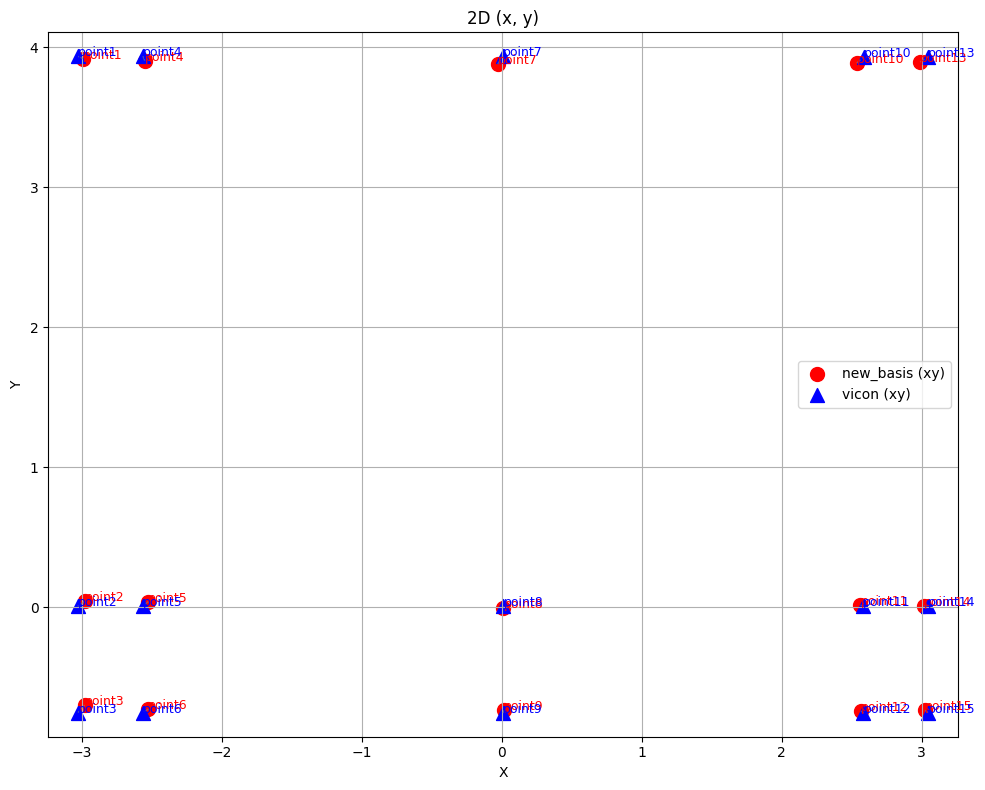

In [51]:
import matplotlib.pyplot as plt

# 收集資料準備繪圖
points_new_basis_xy_all = []
point_vicon_xy_all = []
labels_all = []

for key in sorted_point_names:
    points_new_basis_xy_all.append(points_new_basis[key][:2])
    point_vicon_xy_all.append(vicon_3d_points[key][:2])
    labels_all.append(key)

points_new_basis_xy_all = np.array(points_new_basis_xy_all)
point_vicon_xy_all = np.array(point_vicon_xy_all)

plt.figure(figsize=(10, 8))
plt.scatter(points_new_basis_xy_all[:,0], points_new_basis_xy_all[:,1], 
            c='red', marker='o', s=100, label='new_basis (xy)')
plt.scatter(point_vicon_xy_all[:,0], point_vicon_xy_all[:,1], 
            c='blue', marker='^', s=100, label='vicon (xy)')

# 連接同名點
for i, label in enumerate(labels_all):
    xvalues = [points_new_basis_xy_all[i,0], point_vicon_xy_all[i,0]]
    yvalues = [points_new_basis_xy_all[i,1], point_vicon_xy_all[i,1]]
    plt.plot(xvalues, yvalues, c='gray', linestyle='--', linewidth=1, alpha=0.6)
    plt.text(points_new_basis_xy_all[i,0], points_new_basis_xy_all[i,1], f'{label}', fontsize=9, color='red')
    plt.text(point_vicon_xy_all[i,0], point_vicon_xy_all[i,1], f'{label}', fontsize=9, color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D (x, y)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
